In [31]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [32]:
from torchvision.datasets import ImageFolder
from torchvision.transforms.v2 import ToTensor
import torch.nn as nn
import torch
from tqdm import tqdm
import torchvision.transforms.v2 as v2
from torch import optim
from torchvision import datasets, models, transforms


In [33]:

transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [34]:
from torch.utils.data import random_split
dataset = ImageFolder('./rose_v1', transform=transforms)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
len(dataset)

500

In [36]:

dataset_train, dataset_test = random_split(dataset,[400,100])
len(dataset_train),len(dataset_test)

(400, 100)

In [37]:
from torch.utils.data import DataLoader

data_loader_train = DataLoader(dataset_train, batch_size=32)
for X_train, y_label in data_loader_train:
    print(X_train.shape, y_label.shape)
    break


torch.Size([32, 3, 224, 224]) torch.Size([32])


In [38]:
from torch.utils.data import DataLoader

data_loader_test = DataLoader(dataset_test, batch_size=32)
for X_train, y_label in data_loader_test:
    print(X_train.shape, y_label.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5075778..1.82].


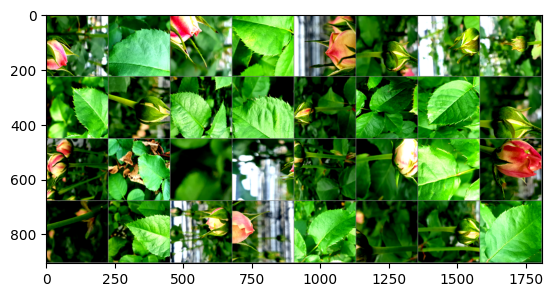

tensor(0) tensor(2) tensor(0) tensor(1)


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
data_iter = iter(data_loader_train)
inputs, classes = next(data_iter)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)
print(' '.join('%5s' % classes[j] for j in range(4)))


In [24]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) 
        self.relu1 = nn.ReLU() 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) 
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)         
        self.fc1 = nn.Linear(32*53*53, 512) 
        self.relu5 = nn.ReLU()         
        self.fc2 = nn.Linear(512, 2) 
        self.output = nn.Softmax(dim=1)        
    
    def forward(self, x):
        out = self.cnn1(x) 
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out) 
        out = self.relu2(out) 
        out = self.maxpool2(out) 
        out = out.view(out.size(0), -1) 
        out = self.fc1(out) 
        out = self.fc2(out)                    
        out = self.output(out)
        return out

In [25]:
model = LeNet()
import time
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

dataloader_dict = {
    'train': data_loader_train,
    'val' : data_loader_test
}

In [26]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    
    since = time.time()
    best_acc = 0.0
   
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
       
        for phase in ['train', 'val']:          
            if phase == 'train':
                model.train()
            else:
                model.eval()
               
            epoch_loss = 0.0
            epoch_corrects = 0
           
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
               
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                   
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                       
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                   
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
           
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
           
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
               
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

SyntaxError: invalid syntax (2176184850.py, line 1)

In [39]:
num_epoch = 12
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/12
--------------------


  0%|          | 0/13 [00:05<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
